In [38]:
import xarray as xr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import distance #La distancia se calcula utilizando la fórmula del haversine, que es una aproximación que toma en cuenta la curvatura de la Tierra.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [39]:
#%% Input 

DIST  = 100# [km] la distancia del radio de búsqueda de las cronologías 
MINS  = 1# el numero mínimo de series que uno desea que incluya la reconstruccion de cada punto de grilla. La información del numero de series aparece en el archivo mismo de cada cronología.
MINFY = 1970#La fecha minima del primer año de la cronología para ser incluida en la reconstruccion. Es decir si la cronología cubre un periodo que va del 1900 al 2020 no podría incluirse en la reconstruccion. 
MINC  =  1#?Numero minimo de cronologias necesarias para incluir como predictores de la variable climatica a reconstruir. 
#ARMOD: Modelo autoregresivo 
NLAG = 1# [años] Permite incluir en el modelo la influencia de años previos. Igual no recuerdo bien si es que solo incluye los lags cuando la regresión es significativa.   
#SCREEN: Esta es una opción para filtrar aquellas cronologías que no están relacionadas con la variable climática. Si le indico que el screen sea de 90, solo me va a dejar las cronologías relacionadas significativamente con el clima al 90%. 
#NTAIL: evaluar la significancia a dos cola de la curva.
#SCALE: No recuerdo que significa. Tengo que chequearlo en mis anotaciones   
#SAVE:  Tampoco lo recuerdo, obviamente es para guardar algo
#WGT: Este es un parametro importante porque permite darle peso a las cronologías que mejor se relacionan con la variable climática.  
#HPLP: Creo que te permite aplicar un filtro de alta o baja frecuencia. No lo use nunca
#NBOOT: Nunca use el boot, ni se para que serviria.

In [40]:
#%% Leer netcdf
dire = '/home/nico/Documentos/PPR/'
#file = 'pdsi_cut.nc'
#file = 'pdsi.mon.mean.nc'
file = 'pdsi_canada_cut.nc'# ncks -d lon,-140.0,-50.0 -d lat,40.0,85.0 pdsi.mon.mean.nc pdsi_canada_cut.nc
#file = 'spei01.nc'
netcdf =  dire+file
ds = xr.open_dataset(netcdf)  # NetCDF or OPeNDAP URL

In [41]:
QTH = "canada" # puede ser "canada" o "chile"

if QTH == "chile":
    path_dir = '/home/nico/Documentos/PPR/'
    std_file = 'std_cronos_PCA_25cronos_07072022_EPSrestriction.csv'
    std_dendro = pd.read_csv(path_dir + std_file, sep =';',index_col=False)
    std_dendro.rename(columns = {"yrs":"time"} , inplace = True)
    std_dendro["time"] = pd.to_datetime(std_dendro["time"], format='%Y',errors = 'coerce')
    std_dendro.dropna(subset = ["time"], inplace = True)#Elimino nos NaN que están en el "time" ¿es necesario?
    #std_dendro.set_index("time",inplace = True)

    #leo las coordenadas
    coord_file = 'LoadingsPCA_22chronos_08072022.csv' 
    qth = pd.read_csv(path_dir + coord_file, sep =';',index_col=0)
    
elif QTH == "canada":
    path_dir = '/home/nico/Documentos/PPR/Canada_dendro/'
    std_file = 'standard_TR_chronologies_punto.csv'
    std_dendro = pd.read_csv(path_dir + std_file, sep =';',index_col=False)
    std_dendro.rename(columns = {"year":"time"} , inplace = True)
    std_dendro["time"] = pd.to_datetime(std_dendro["time"], format='%Y',errors = 'coerce')
    std_dendro.dropna(subset = ["time"], inplace = True)#Elimino nos NaN que están en el "time" ¿es necesario?
    #std_dendro.set_index("time",inplace = True)

    #leo las coordenadas
    coord_file = 'sites_canada_punto.csv' 
    qth = pd.read_csv(path_dir + coord_file, sep =';',index_col=0,skiprows=1)
    qth = qth.dropna(subset=["Lat","Long"])
    qth = qth.rename(columns={'Long': 'Lon'})

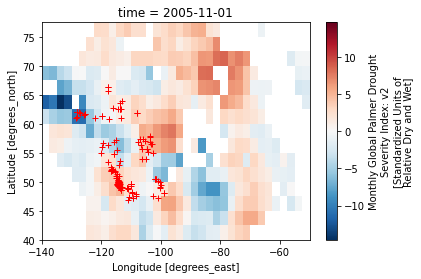

In [42]:
tiempo = 1630
#tiempo = 1450
ds_tiempo = ds.isel(time = tiempo)
pdsi = ds_tiempo['pdsi']

plt.figure()
pdsi.plot()
plt.plot(qth['Lon'],qth['Lat'],'r+')

### Voy a seleccionar las cronologías donde más datos hay [entre 1900 y 1990]

In [43]:
std_dendro = std_dendro[(std_dendro['time'].dt.year >= 1900) & (std_dendro['time'].dt.year <= 1990)]

In [44]:
# Eliminar las columnas con NaN, en efecto elimina unas pocas
std_dendro = std_dendro.dropna(axis=1)

(40.0, 75.0)

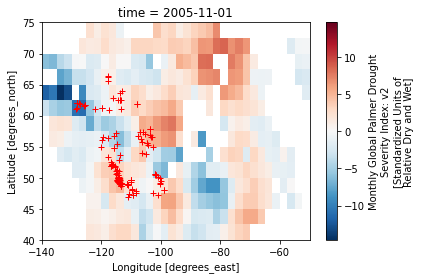

In [45]:
plt.figure()
pdsi.plot()
plt.plot(qth['Lon'],qth['Lat'],'r+')
# Establecer los límites del eje x (longitud) y eje y (latitud) para Canadá
plt.xlim(-140, -50)  # Ajustar los límites de longitud según sea necesario
plt.ylim(40, 75)  # Ajustar los límites de latitud según sea necesario


In [46]:
#%% obtengo las latitudes y longitudes del xarray
latitud_field = ds.lat.values
longitd_field = ds.lon.values

In [47]:
latitud_field

array([41.25, 43.75, 46.25, 48.75, 51.25, 53.75, 56.25, 58.75, 61.25,
       63.75, 66.25, 68.75, 71.25, 73.75, 76.25], dtype=float32)

In [48]:
#%% Busqueda de distancias entre los puntos del grillado y la ubicación de los árboles
#La distancia se calcula utilizando la fórmula del haversine, que es una aproximación que toma en cuenta la curvatura de la Tierra.

coordenadas = np.array([qth['Lat'],qth['Lon']])
coordenadas = np.transpose(coordenadas)
#coordenadas

In [49]:
qth["Code"][1]

'RWI'

In [50]:
distancias_km = []


for i in ds.lat.values:
    for j in ds.lon.values:
        sitio_cercano = []
        #value = ds.sel(lat=i, lon=j)
        #print(value)
        #latitud = ds.lat.sel(lat=ds.lat[i]).values
        #print(ds.lat.sel(lat=ds.lat[i]).values)
        #longitud = ds.lon.sel(lon=ds.lon[j]).values
        print("latitud : " +str(i)+" longitud : "+str(j))
        #np.array([latitud,longitud])
        punto_grilla = [i,j]
        
        for s in range(len(coordenadas)):
            coord = coordenadas[s]
            distancia_km = distance(punto_grilla, coord).km
            distancias_km.append(distancia_km)
            if distancia_km < DIST:
                print ("Punto grilla tiene cronologia cercana!")
                #print(s)
                print(qth["Code"][s])
                sitio_cercano.append(qth["Code"][s])
            #print(f"La distancia es de {distancia_km:.2f} km")
        print(sitio_cercano)
        print(len(sitio_cercano))#cantidad de cronos cercanas 
        
        '''
        # Crear una lista para almacenar las columnas extraídas
        columnas_extraidas = []

        # Iterar sobre los nombres de columna y comprobar si están en el DataFrame
        for columna in sitio_cercano:
            if columna in df.columns:
                columnas_extraidas.append(std_dendro[columna])
            else:
                print(f"La columna '{columna}' no está presente en el DataFrame.")

        # Concatenar las columnas extraídas en un nuevo DataFrame
        df = pd.concat(columnas_extraidas, axis=1)

        
        
        
        #df = std_dendro[sitio_cercano]
        
        '''
        

latitud : 41.25 longitud : -138.75
[]
0
latitud : 41.25 longitud : -136.25
[]
0
latitud : 41.25 longitud : -133.75
[]
0
latitud : 41.25 longitud : -131.25
[]
0
latitud : 41.25 longitud : -128.75
[]
0
latitud : 41.25 longitud : -126.25
[]
0
latitud : 41.25 longitud : -123.75
[]
0
latitud : 41.25 longitud : -121.25
[]
0
latitud : 41.25 longitud : -118.75
[]
0
latitud : 41.25 longitud : -116.25
[]
0
latitud : 41.25 longitud : -113.75
[]
0
latitud : 41.25 longitud : -111.25
[]
0
latitud : 41.25 longitud : -108.75
[]
0
latitud : 41.25 longitud : -106.25
[]
0
latitud : 41.25 longitud : -103.75
[]
0
latitud : 41.25 longitud : -101.25
[]
0
latitud : 41.25 longitud : -98.75
[]
0
latitud : 41.25 longitud : -96.25
[]
0
latitud : 41.25 longitud : -93.75
[]
0
latitud : 41.25 longitud : -91.25
[]
0
latitud : 41.25 longitud : -88.75
[]
0
latitud : 41.25 longitud : -86.25
[]
0
latitud : 41.25 longitud : -83.75
[]
0
latitud : 41.25 longitud : -81.25
[]
0
latitud : 41.25 longitud : -78.75
[]
0
latitud :

[]
0
latitud : 51.25 longitud : -96.25
[]
0
latitud : 51.25 longitud : -93.75
[]
0
latitud : 51.25 longitud : -91.25
[]
0
latitud : 51.25 longitud : -88.75
[]
0
latitud : 51.25 longitud : -86.25
[]
0
latitud : 51.25 longitud : -83.75
[]
0
latitud : 51.25 longitud : -81.25
[]
0
latitud : 51.25 longitud : -78.75
[]
0
latitud : 51.25 longitud : -76.25
[]
0
latitud : 51.25 longitud : -73.75
[]
0
latitud : 51.25 longitud : -71.25
[]
0
latitud : 51.25 longitud : -68.75
[]
0
latitud : 51.25 longitud : -66.25
[]
0
latitud : 51.25 longitud : -63.75
[]
0
latitud : 51.25 longitud : -61.25
[]
0
latitud : 51.25 longitud : -58.75
[]
0
latitud : 51.25 longitud : -56.25
[]
0
latitud : 51.25 longitud : -53.75
[]
0
latitud : 51.25 longitud : -51.25
[]
0
latitud : 53.75 longitud : -138.75
[]
0
latitud : 53.75 longitud : -136.25
[]
0
latitud : 53.75 longitud : -133.75
[]
0
latitud : 53.75 longitud : -131.25
[]
0
latitud : 53.75 longitud : -128.75
[]
0
latitud : 53.75 longitud : -126.25
[]
0
latitud : 53.7

[]
0
latitud : 61.25 longitud : -53.75
[]
0
latitud : 61.25 longitud : -51.25
[]
0
latitud : 63.75 longitud : -138.75
[]
0
latitud : 63.75 longitud : -136.25
[]
0
latitud : 63.75 longitud : -133.75
[]
0
latitud : 63.75 longitud : -131.25
[]
0
latitud : 63.75 longitud : -128.75
[]
0
latitud : 63.75 longitud : -126.25
[]
0
latitud : 63.75 longitud : -123.75
[]
0
latitud : 63.75 longitud : -121.25
[]
0
latitud : 63.75 longitud : -118.75
[]
0
latitud : 63.75 longitud : -116.25
[]
0
latitud : 63.75 longitud : -113.75
Punto grilla tiene cronologia cercana!
LCL
Punto grilla tiene cronologia cercana!
SHL
['LCL', 'SHL']
2
latitud : 63.75 longitud : -111.25
Punto grilla tiene cronologia cercana!
SHL
['SHL']
1
latitud : 63.75 longitud : -108.75
[]
0
latitud : 63.75 longitud : -106.25
[]
0
latitud : 63.75 longitud : -103.75
[]
0
latitud : 63.75 longitud : -101.25
[]
0
latitud : 63.75 longitud : -98.75
[]
0
latitud : 63.75 longitud : -96.25
[]
0
latitud : 63.75 longitud : -93.75
[]
0
latitud : 63.7

[]
0
latitud : 76.25 longitud : -101.25
[]
0
latitud : 76.25 longitud : -98.75
[]
0
latitud : 76.25 longitud : -96.25
[]
0
latitud : 76.25 longitud : -93.75
[]
0
latitud : 76.25 longitud : -91.25
[]
0
latitud : 76.25 longitud : -88.75
[]
0
latitud : 76.25 longitud : -86.25
[]
0
latitud : 76.25 longitud : -83.75
[]
0
latitud : 76.25 longitud : -81.25
[]
0
latitud : 76.25 longitud : -78.75
[]
0
latitud : 76.25 longitud : -76.25
[]
0
latitud : 76.25 longitud : -73.75
[]
0
latitud : 76.25 longitud : -71.25
[]
0
latitud : 76.25 longitud : -68.75
[]
0
latitud : 76.25 longitud : -66.25
[]
0
latitud : 76.25 longitud : -63.75
[]
0
latitud : 76.25 longitud : -61.25
[]
0
latitud : 76.25 longitud : -58.75
[]
0
latitud : 76.25 longitud : -56.25
[]
0
latitud : 76.25 longitud : -53.75
[]
0
latitud : 76.25 longitud : -51.25
[]
0


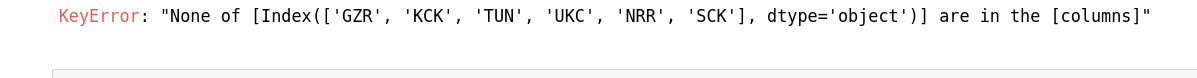

# Preparo el df

In [51]:
#sitio = ['GZR', 'KCK', 'TUN', 'UKC', 'NRR', 'SCK']
sitio = ['time','CAB','JOLA','CMT','DEA','TWO']
df = std_dendro[sitio]

In [52]:
df.head()

,time,CAB,JOLA,CMT,DEA,TWO
862,1900-01-01,1.438,1.554,1.443,1.826,2.115
863,1901-01-01,1.316,1.596,1.332,1.824,2.203
864,1902-01-01,1.773,1.644,1.115,1.570,1.979
865,1903-01-01,1.604,1.374,0.998,1.254,1.448
866,1904-01-01,1.284,1.664,1.078,1.626,1.880


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 862 to 952
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    91 non-null     datetime64[ns]
 1   CAB     91 non-null     float64       
 2   JOLA    91 non-null     float64       
 3   CMT     91 non-null     float64       
 4   DEA     91 non-null     float64       
 5   TWO     91 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.0 KB


In [54]:
df.loc[:,"year"] = df["time"].dt.year

/tmp/ipykernel_33037/1320052726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"year"] = df["time"].dt.year


In [55]:
df.head()

,time,CAB,JOLA,CMT,DEA,TWO,year
862,1900-01-01,1.438,1.554,1.443,1.826,2.115,1900
863,1901-01-01,1.316,1.596,1.332,1.824,2.203,1901
864,1902-01-01,1.773,1.644,1.115,1.570,1.979,1902
865,1903-01-01,1.604,1.374,0.998,1.254,1.448,1903
866,1904-01-01,1.284,1.664,1.078,1.626,1.880,1904


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 862 to 952
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    91 non-null     datetime64[ns]
 1   CAB     91 non-null     float64       
 2   JOLA    91 non-null     float64       
 3   CMT     91 non-null     float64       
 4   DEA     91 non-null     float64       
 5   TWO     91 non-null     float64       
 6   year    91 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.7 KB


# Preparo el pdsi 

/home/nico/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nico/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


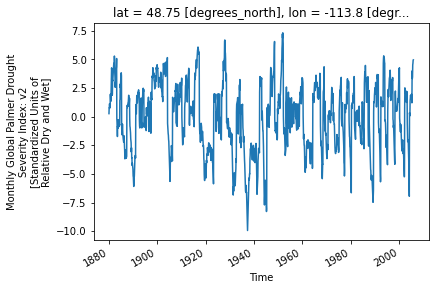

In [57]:
TS = ds.sel(lon = -114, lat = 49.7, method='nearest')# escogí un punto arbitrario
plt.figure()
TS['pdsi'].plot()

In [58]:
pdsi = TS['pdsi']
pdsi = pdsi.to_pandas()
pdsi = pdsi.to_frame()
pdsi.rename(columns = {0:"pdsi"} , inplace = True)
pdsi.reset_index(inplace = True)


pdsi.head()



pdsi_y = pdsi.groupby(pdsi.time.dt.year)['pdsi'].mean()#calculo el promedio anual
pdsi_y = pdsi_y.to_frame()
pdsi_y.reset_index(inplace = True)
pdsi_y.columns = ['year', 'pdsi']

pdsi_y

,year,pdsi
0,1870,NaN
1,1871,NaN
2,1872,NaN
3,1873,NaN
4,1874,NaN
...,...,...
131,2001,-2.704023
132,2002,-0.321046
133,2003,-0.385681
134,2004,-1.020114


# Promedios anuales de pdsi

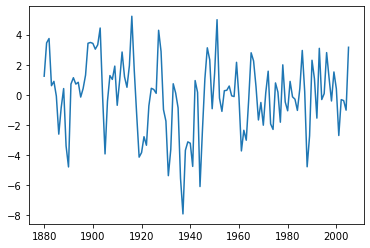

In [60]:
plt.figure()
plt.plot(pdsi_y["year"],pdsi_y["pdsi"])

In [27]:
#df = df.set_index('year')
#pdsi_y = pdsi_y.set_index('year')

In [30]:
#df.drop('time', axis=1,inplace=True)

In [61]:
pdsi_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    136 non-null    int64  
 1   pdsi    126 non-null    float32
dtypes: float32(1), int64(1)
memory usage: 1.7 KB


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 862 to 952
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    91 non-null     datetime64[ns]
 1   CAB     91 non-null     float64       
 2   JOLA    91 non-null     float64       
 3   CMT     91 non-null     float64       
 4   DEA     91 non-null     float64       
 5   TWO     91 non-null     float64       
 6   year    91 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.7 KB


In [73]:
df.head()

,time,CAB,JOLA,CMT,DEA,TWO,year
862,1900-01-01,1.438,1.554,1.443,1.826,2.115,1900
863,1901-01-01,1.316,1.596,1.332,1.824,2.203,1901
864,1902-01-01,1.773,1.644,1.115,1.570,1.979,1902
865,1903-01-01,1.604,1.374,0.998,1.254,1.448,1903
866,1904-01-01,1.284,1.664,1.078,1.626,1.880,1904


In [64]:
# Calcular el PCA
X = df.drop(['year','time'], axis=1).values
pca = PCA(n_components=5)
principal_components = pca.fit_transform(X)

# Crear un dataframe para los componentes principales
principal_df = pd.DataFrame(principal_components, columns=['PC{}'.format(i) for i in range(1, 6)])

In [83]:
# Obtener la varianza explicada
varianza_explicada = pca.explained_variance_ratio_

# Imprimir la varianza explicada para cada componente
for i, varianza in enumerate(varianza_explicada):
    print(f"Componente {i+1}: {varianza}")

Componente 1: 0.7023573183208167
Componente 2: 0.15011733123099422
Componente 3: 0.06528235928901366
Componente 4: 0.04442854198373479
Componente 5: 0.0378144491754407


In [69]:
principal_df

,PC1,PC2,PC3,PC4,PC5
0,1.610309,-0.224413,0.218217,-0.172316,0.060627
1,1.595009,-0.367208,0.261563,-0.099863,-0.034052
2,1.515171,0.168314,0.185687,0.138547,-0.165119
3,0.841840,0.321806,0.058160,0.124275,-0.105411
4,1.261032,-0.226767,0.111257,0.000258,-0.257246
...,...,...,...,...,...
86,-0.241840,0.137094,0.272538,-0.058122,-0.002477
87,-0.640396,-0.145018,0.280241,-0.331616,-0.064710
88,-0.552484,-0.214238,0.107720,-0.231842,0.018763
89,-0.521541,-0.039084,0.123196,-0.307753,0.050377


# Preparo el entrenamiento 

In [71]:
X_train = principal_df[['PC1']]

In [ ]:
pdsi_recortado = pdsi_y[(pdsi_y['year'] >= 1900) & (pdsi_y['year'] <= 1990)]

In [78]:
pdsi_recortado

,year,pdsi
30,1900,3.412971
31,1901,3.030641
32,1902,3.319817
33,1903,4.433795
34,1904,-0.108589
...,...,...
116,1986,2.944427
117,1987,0.209194
118,1988,-4.781625
119,1989,-2.731315


In [79]:
y_train = pdsi_recortado.drop('year', axis=1).values

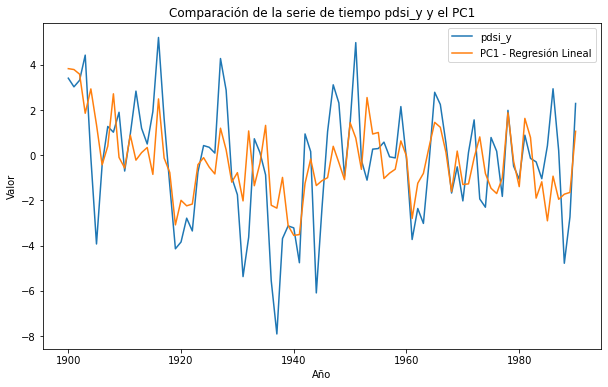

In [82]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_train)

# Graficar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df['year'], y_train, label='pdsi_y')
plt.plot(df['year'], y_pred, label='PC1 - Regresión Lineal')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Comparación de la serie de tiempo pdsi_y y el PC1')
plt.legend()
plt.show()